# Import Libraries

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import math
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
import re
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [15]:
df = pd.read_csv('IMDB Dataset.csv', on_bad_lines='skip', engine='python')

In [16]:
df['review_length'] = df['review'].apply(lambda x: len(x.split()))

In [17]:
df.head(10)

,review,sentiment,review_length
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230
5,"Probably my all-time favorite movie, a story o...",positive,119
6,I sure would like to see a resurrection of a u...,positive,150
7,"This show was an amazing, fresh & innovative i...",negative,174
8,Encouraged by the positive comments about this...,negative,130
9,If you like original gut wrenching laughter yo...,positive,33


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   review         50000 non-null  object
 1   sentiment      50000 non-null  object
 2   review_length  50000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [19]:
df.describe()

,review_length
count,50000.000000
mean,231.156940
std,171.343997
min,4.000000
25%,126.000000
50%,173.000000
75%,280.000000
max,2470.000000


##  Sentiment Distribution (Bar Plot & Histogram)

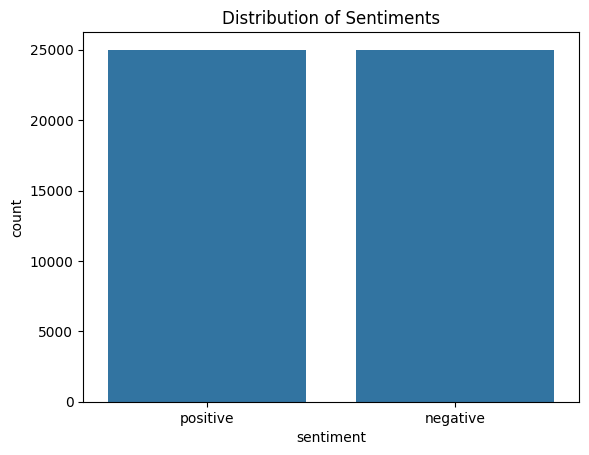

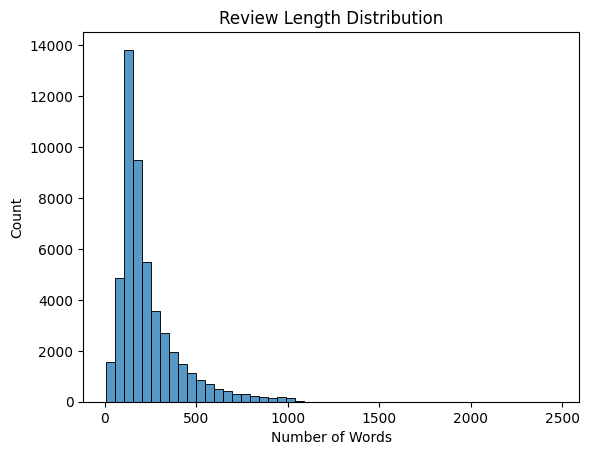

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiments')
plt.show()

sns.histplot(df['review_length'], bins=50)
plt.title('Review Length Distribution')
plt.xlabel('Number of Words')
plt.show()


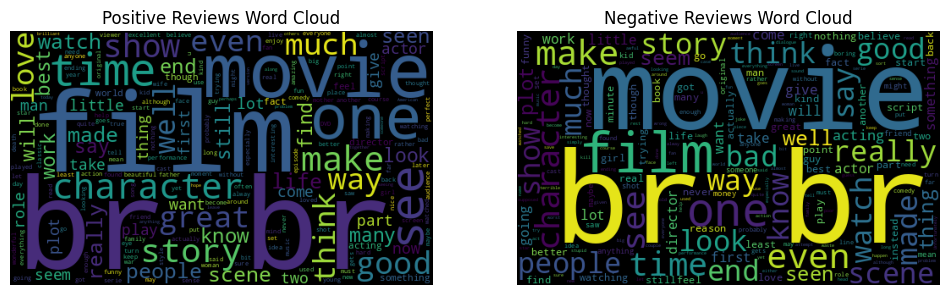

In [21]:
from wordcloud import WordCloud

pos_text = " ".join(df[df['sentiment'] == 'positive']['review'])
neg_text = " ".join(df[df['sentiment'] == 'negative']['review'])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=500, height=300).generate(pos_text))
plt.title("Positive Reviews Word Cloud")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=500, height=300).generate(neg_text))
plt.title("Negative Reviews Word Cloud")
plt.axis("off")
plt.show()


# Preprocessing & Feature Engineering

In [27]:
# Check for missing values
print(df.isnull().sum())
# Drop or fill missing rows
df.dropna(subset=['review', 'sentiment'], inplace=True)

def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()  # remove HTML
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # remove punctuation/numbers
    text = text.lower()  # lowercase
    return text

df['cleaned_review'] = df['review'].apply(clean_text)

#Tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
df['tokens'] = df['cleaned_review'].apply(word_tokenize)

#remove stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df['tokens_no_stopwords'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# Re-join tokens for TF-IDF
df['processed_text'] = df['tokens_no_stopwords'].apply(lambda x: " ".join(x))

tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['processed_text'])

review            0
sentiment         0
review_length     0
cleaned_review    0
dtype: int64


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [30]:
y = df['sentiment']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [31]:
df.head()

,review,sentiment,review_length,cleaned_review,tokens,tokens_no_stopwords,processed_text
0,One of the other reviewers has mentioned that ...,positive,307,one of the other reviewers has mentioned that ...,"[one, of, the, other, reviewers, has, mentione...","[one, reviewers, mentioned, watching, oz, epis...",one reviewers mentioned watching oz episode yo...
1,A wonderful little production. <br /><br />The...,positive,162,a wonderful little production the filming tech...,"[a, wonderful, little, production, the, filmin...","[wonderful, little, production, filming, techn...",wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,166,i thought this was a wonderful way to spend ti...,"[i, thought, this, was, a, wonderful, way, to,...","[thought, wonderful, way, spend, time, hot, su...",thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,138,basically theres a family where a little boy j...,"[basically, theres, a, family, where, a, littl...","[basically, theres, family, little, boy, jake,...",basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230,petter matteis love in the time of money is a ...,"[petter, matteis, love, in, the, time, of, mon...","[petter, matteis, love, time, money, visually,...",petter matteis love time money visually stunni...


# Traditional ML Model: Logistic Regression

In [32]:
# X_tfidf is your feature matrix from TF-IDF
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [33]:
from sklearn.linear_model import LogisticRegression

# Initialize and train
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_pred = lr_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Accuracy: 0.8868
Precision: 0.877926097891275
Recall: 0.9005755110140901
F1 Score: 0.8891065830721003


# Naïve Bayes

In [35]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_pred_nb = nb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb))
print("Recall:", recall_score(y_test, y_pred_nb))
print("F1 Score:", f1_score(y_test, y_pred_nb))

Accuracy: 0.8492
Precision: 0.8481561822125814
Recall: 0.8535423695177614
F1 Score: 0.8508407517309594
